## 절차

|절차|단계|목표/설명|
|-|-|-|
|1|연구목표|사용자가 입력한 텍스트를 예측하여 어떤 언어인지 판독한다(영어권)<br>머신러닝의 사용 여부 판단(굳이 사용 안해도 처리 가능하면 제외<br>머신러닝을 적용, 지도학습법을 사용<br>알고리즘은 여러 개를 테스트하여 최적화가 된 알고리즘을 사용(파라미터 적용)|
|2|데이터 획득/수집|실전 : 위키피디아/소설/법률 등 텍스트 크롤링<br>임시 : 제공데이터(법령/대본 등)|
|3|데이터 준비/통찰/전처리|텍스트에서 알파벳의 출현 빈도를 계산하여 벡터화<br>훈련데이터/테스트데이터 구성|
|4|데이터 탐색/통찰/시각화|언어별로 알파벳이 출현하는(or 알파벳을 사용하는) 빈도가 다르다는 명제를 확인<br>시각화를 진행<br>바차트를 국가별로 비교, 선형차트를 통해서 빈도의 차이점 시각화|
|5|데이터 모델링 or 모델구축|- 학습<br>- 예측<br>- 정답률<br>- 성능평가<br>- 알고리즘체인/파이프라인 구축<br>- 하이퍼파라미터 튜닝<br>- 연구목표에서 설정한 목표치까지 도달할 때까지 반복|
|6|시스템 통합 or 솔루션/서비스/레포트|- 모델을 덤프 → flask 웹 서비스 기반에 연동 → 서비스 구성<br>- 모델을 업그레이드/다운그레이드가 자동화될 수 있게 구성<br>- 선순환구조(사용자가 사용하면 할수록 그 데이터가 다시 모여서 학습 → 성능을 향상 → 업데이트|

### 1. 연구목표
- 사용자가 입력한 텍스트를 예측하여 어떤 언어인지 판독한다(영어권)

### 2. 데이터 획득/수집
- 영어 샘플 사이트 : https://en.wikipedia.org/wiki/BTS_(band)
- #mw-content-text p

In [2]:
# 2-1. 실전용 : 미국, 프랑스, 인도네시아, 타갈리아어 등의 위키피디아의 텍스트 수집
#               수집된 정량은 비슷한 분량으로 준비
import urllib.request as req
from bs4 import BeautifulSoup

In [3]:
# 2-2. 요청 및 soup로 구성
target_url = 'https://en.wikipedia.org/wiki/BTS_(band)'
soup = BeautifulSoup( req.urlopen( target_url ), 'html5lib' )

In [5]:
# soup
type(soup)

bs4.BeautifulSoup

In [7]:
# 2-3. 테이터 추출
output = soup.select('#mw-content-text p')
len(output)

64

In [9]:
# 2-4. 리스트에 모든 텍스트를 담아라(멤버로)
# for p in output → p tag가 하나씩 나온다
texts = [ p.text for p in output ]
texts[:3]

['\n\n',
 '\n',
 'BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band formed in Seoul in 2013. The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. Popular for their live performances, the group have staged several world tours.\n']

In [12]:
import re

In [15]:
# 2-5. 정규식 처리
# 통합, 조인 ↔ 분해(의 결과물은 리스트)
str_text = ' '.join(texts)
str_text[:20]
# 영어, 공백(단어 구분) 빼고 다 제거
p = re.compile('[^a-zA-Z ]')
m = p.sub( '', str_text )
print(m[:50])

  BTS Korean RRBangtan Sonyeondan also known as th


In [ ]:
# 위와 같은 방식으로 데이터를 언어별로 수집
# → 대량의 데이터를 확보한다 (충분한 학습을 수행하기 위한 재료)
# 이렇게 모아진 데이터를 사용하여 학습 진행

### 3. 데이터 준비/통찰/전처리 + 시각화
- 제공되는 모든 데이터를 읽어서 처리
- 알파벳의 빈도를 계산하여 수치화

In [16]:
# 파일 목록 리스트
import glob, os.path, re, json

file_list = glob.glob('../data/train/*.txt')
file_list

['../data/train\\en-1.txt',
 '../data/train\\en-2.txt',
 '../data/train\\en-3.txt',
 '../data/train\\en-4.txt',
 '../data/train\\en-5.txt',
 '../data/train\\fr-10.txt',
 '../data/train\\fr-6.txt',
 '../data/train\\fr-7.txt',
 '../data/train\\fr-8.txt',
 '../data/train\\fr-9.txt',
 '../data/train\\id-11.txt',
 '../data/train\\id-12.txt',
 '../data/train\\id-13.txt',
 '../data/train\\id-14.txt',
 '../data/train\\id-15.txt',
 '../data/train\\tl-16.txt',
 '../data/train\\tl-17.txt',
 '../data/train\\tl-18.txt',
 '../data/train\\tl-19.txt',
 '../data/train\\tl-20.txt']

In [24]:
# 파일을 읽어서
# 빈도 계산
# 지도 방식 데이터로 구성 : 변수(a-z) + 답안(1개)

def check_lang_freq ( file_path ) :
    
    # Section 1
    # --------------------------------------------------------------------------
    # 1. 정답 변수(컬럼)를 구성
    # '../data/train\\en-1.txt' → 'en'(정답) 추출
    # file_path를 통찰해보니, 위치가 변경되면 정규식이 적용이 안 될 수 있다
    # 파일명을 추출하여 거기서 정규식을 적용하는 것이 합리적 → 경로가 바뀌어도 ok
    name = os.path.basename( file_path )
    # print(name)    # en-1.txt
    p = re.compile('^[a-z]{2,}')
    lang = p.match(name).group()
    # print(name, lang)
    # -------------------------------------------------------------------------------
    
    # Section 2
    # -------------------------------------------------------------------------------
    # 알파벳 빈도 계산
    # 2. 파일을 오픈 → 읽고 → 닫기 → [0, 0, 0, 0, 0, 0, 0, 0, 0, ,,, 0]
    with open ( file_path, 'r', encoding='utf-8') as f :
        # 데이터를 들여다보니 대소문자가 섞여 있다
        # 대소문자는 아스키 값이 다르니 한쪽 방향으로 통일해야 한다
        # 여기서는 소문자로 통일
        text = f.read().lower()
        p = re.compile('[^a-zA-Z]*')
        text = p.sub('', text)
    # 알파벳 순서대로 빈도수 기록
    # a-a = 0, b-a = 1, c-a = 2, ... z-a = 25 → 빈도를 기록할 인덱스와 동일
    cnts = [ 0 for n in range(26) ]
    # 아스키 환산함수 : ord()
    # print(ord('a'), ord('z'), ord(' ')) : 97 122 32
    asc_a, asc_z, asc_ws = ord('a'), ord('z'), ord(' ')
    for ch in text :
        # ch를 아스키로 변환
        # if asc_a <= ord(ch) <= asc_z :  # 알파벳이 맞으면
        if ord(ch) != asc_ws :
            cnts[ord(ch)-asc_a] += 1
    # -------------------------------------------------------------------------------

    # Section 3
    # -------------------------------------------------------------------------------
    # 3. 빈도는 파일 한 개 내 전체 charater 수 대비 해당 a~z까지의 빈도수로 표현
    # → 데이터를 같은 구간에 배치 → 정규화 0 ~ 1 사이에 배치
    # 전체 빈도
    total_cnt = sum(cnts)
    freq = list( map( lambda x : x/total_cnt , cnts) )
    # -------------------------------------------------------------------------------

    # Section 4
    # -------------------------------------------------------------------------------
    # 4. 리턴 : 정답, 빈도를 담는 리스트
    # -------------------------------------------------------------------------------
    
    return lang, freq

In [26]:
# for file in file_list :
#     print(check_lang_freq(file))

In [27]:
# 특정 폴더 내의 데이터를 읽어서 빈도로 리턴
def load_files( file_glob ) :
    file_list = glob.glob( file_glob )
    langs = []
    freqs = []
    for file in file_list :
        lang, freq = check_lang_freq(file)
        langs.append(lang)
        freqs.append(freq)
    # 딕셔너리 형태로 리턴
    return { 'labels' : langs, 'freqs' : freqs }

In [28]:
# 데이터 로드
train_data = load_files('../data/train/*.txt')
test_data = load_files('../data/test/*.txt')

In [29]:
# 데이터 확인
len(train_data['labels']), len(test_data['labels'])

(20, 8)

In [30]:
# 데이터 적재
# 자료구조를 그대로 유지해서 저장 → json 모듈로 처리
with open( '../data/lang_label_freq.json', 'w', encoding='utf-8' ) as f :
    json.dump( [train_data, test_data], f )

### 4. 데이터 탐색/통찰/시각화

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import json
%matplotlib inline

In [32]:
# 데이터 로드
with open( '../data/lang_label_freq.json', 'r', encoding='utf-8' ) as fp :
    freq = json.load(fp)

In [33]:
# 데이터 구조 확인, 데이터 들여다보기
freq

[{'labels': ['en',
   'en',
   'en',
   'en',
   'en',
   'fr',
   'fr',
   'fr',
   'fr',
   'fr',
   'id',
   'id',
   'id',
   'id',
   'id',
   'tl',
   'tl',
   'tl',
   'tl',
   'tl'],
  'freqs': [[0.07595212187159957,
    0.012840043525571273,
    0.04570184983677911,
    0.04613710554951034,
    0.10533188248095757,
    0.015669205658324265,
    0.019151251360174103,
    0.043743199129488576,
    0.07399347116430903,
    0.0017410228509249185,
    0.00544069640914037,
    0.05375408052230685,
    0.026332970620239392,
    0.07747551686615888,
    0.08966267682263329,
    0.016539717083786723,
    0.0,
    0.07769314472252448,
    0.061371055495103376,
    0.08052230685527748,
    0.02589771490750816,
    0.009793253536452665,
    0.014145810663764961,
    0.0006528835690968443,
    0.02002176278563656,
    0.0004352557127312296],
   [0.08417789436031954,
    0.019911768212710148,
    0.030404196971503518,
    0.038869679265529984,
    0.13699773458924527,
    0.0174078931679980

In [42]:
# 훈련 데이터 : freq[0]
len(freq[0]['labels']), len(freq[0]['freqs'])

(20, 20)

In [43]:
# 테스트 데이터 : freq[1]
len(freq[1]['labels']), len(freq[1]['freqs'])

(8, 8)

In [44]:
# 훈련데이터를 df로 변환
df_freq = pd.DataFrame(freq[0]['freqs'])
df_freq

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.000000,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.005485,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596
2,0.071646,0.012172,0.045643,0.032642,0.120055,0.014661,0.025173,0.023513,0.094606,0.002490,...,0.001660,0.053942,0.087967,0.081051,0.029046,0.018811,0.011895,0.000553,0.017981,0.000553
3,0.072210,0.027715,0.029977,0.039593,0.121041,0.016780,0.023567,0.059012,0.065234,0.001508,...,0.000377,0.059201,0.073341,0.093703,0.024321,0.005090,0.019608,0.006033,0.017534,0.001697
4,0.073806,0.020368,0.031099,0.039641,0.141261,0.020368,0.020368,0.056943,0.065046,0.003285,...,0.000438,0.072492,0.059571,0.095488,0.024967,0.010731,0.023872,0.003066,0.014893,0.000657
5,0.078738,0.010451,0.037253,0.053283,0.150487,0.016222,0.010708,0.015517,0.069377,0.002308,...,0.005899,0.075083,0.071621,0.077584,0.053475,0.014299,0.000705,0.003911,0.003655,0.000834
6,0.077913,0.014919,0.035749,0.044830,0.149735,0.011784,0.011496,0.012613,0.072003,0.002126,...,0.006847,0.074741,0.082093,0.070561,0.054452,0.010631,0.004541,0.003892,0.005334,0.000468
7,0.072717,0.013065,0.035412,0.044990,0.150754,0.010523,0.010582,0.011528,0.071416,0.003015,...,0.006621,0.076914,0.078333,0.065681,0.050902,0.012711,0.002601,0.004966,0.004848,0.000118
8,0.072599,0.015761,0.039836,0.051129,0.157111,0.013031,0.013527,0.014396,0.085629,0.004344,...,0.005833,0.082030,0.066518,0.061057,0.042690,0.015140,0.000745,0.005088,0.004964,0.001986
9,0.078947,0.011501,0.035283,0.051852,0.143275,0.012086,0.020078,0.019493,0.089864,0.003899,...,0.004678,0.077778,0.072320,0.063353,0.043860,0.014035,0.000390,0.003314,0.005263,0.001170


In [45]:
df_label = pd.DataFrame(freq[0]['labels'])
df_label

,0
0,en
1,en
2,en
3,en
4,en
5,fr
6,fr
7,fr
8,fr
9,fr


In [48]:
# df_label의 컬럼명을 0 → 'label'로 수정
df_label.columns = ['label']
df_label.head(2)

,label
0,en
1,en


In [49]:
# df_freq, df_label 데이터프레임을 합치시오 → 20x27 형태
df_freq.shape, df_label.shape

((20, 26), (20, 1))

In [54]:
# 병합 1 : concat()
df_tmp = pd.concat([df_freq, df_label], sort=True, axis = 1)
df_tmp.shape

(20, 27)

In [55]:
# 병합 2 : merge()
df_tmp = pd.merge(df_freq, df_label, left_index=True, right_index=True)
df_tmp.shape

(20, 27)

In [56]:
# 알파벳 문자열 지원
from string import ascii_lowercase
ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [61]:
# df_tmp의 컬럼명 0-25를 a-z로 대체
# a,b,c ... z, label
df_tmp.columns = list(ascii_lowercase) + [df_tmp.columns[-1]]
df_tmp.columns

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'label'],
      dtype='object')

In [62]:
df_tmp.head(2)

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en


In [72]:
# 알파벳을 인덱스로, 국가를 컬럼으로 배치
# 빈도수 평균 (국가별로)
# df_tmp_pv
# df_tmp_pv = df_tmp.pivot_table(columns = df_tmp.label)
df_tmp_pv = pd.pivot_table(df_tmp, 
                           columns = df_tmp['label'])
df_tmp_pv.head(5)

label,en,fr,id,tl
a,0.075558,0.076183,0.160047,0.210537
b,0.018601,0.013140,0.026276,0.021824
c,0.036565,0.036707,0.008391,0.010842
d,0.039376,0.049217,0.038213,0.019756
e,0.124937,0.150272,0.085395,0.041240


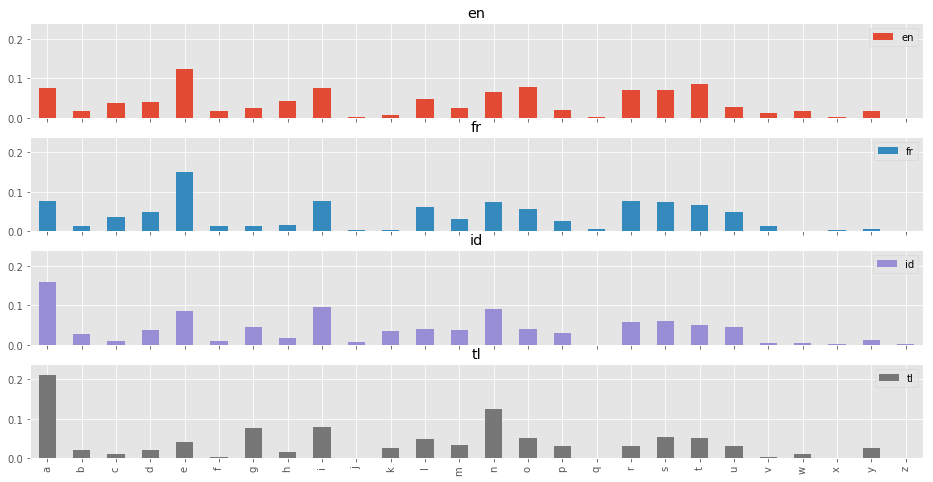

In [76]:
# 막대 그래프로 비교
plt.style.use('ggplot')
# y축 단위를 통일시키기 위해 ylim 사용
df_tmp_pv.plot(kind = 'bar', subplots = True, figsize=(16, 8), ylim=(0, 0.24) )
# 차트 저장
plt.savefig('../data/national_frequency.png')
plt.show()

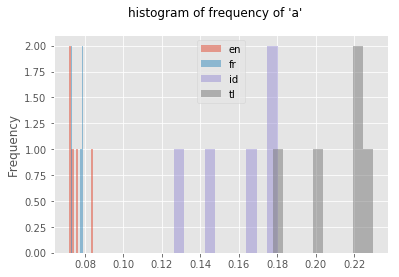

In [89]:
# 히스토그램을 이용하여 알파벳 하나에 대한 '국가별' 비교
# a 문자가 국가별 단어에 사용되는 빈도수를 히스토그램으로 표현
# df_tmp 데이터를 이용하여 국가별 a의 빈도를 히스토그램으로 표현하시오
# 데이터를 돌면서 답안(label) 체크
# df_tmp['label'].unique()
for na in df_tmp['label'].unique() :
    # 국가별로 돌면서 해당 국가의 데이터만 획득
    df_tmp_na = df_tmp[df_tmp['label']==na]
    # 국가별 시각화
    # 한 번에 그려지는 데이터는 동일 색상으로 처리
    df_tmp_na['a'].plot(kind = 'hist', alpha = 0.5, label = na)
plt.legend()
plt.suptitle("histogram of frequency of 'a'")
plt.show()

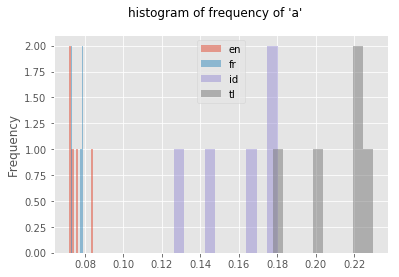

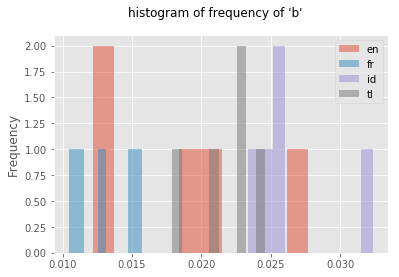

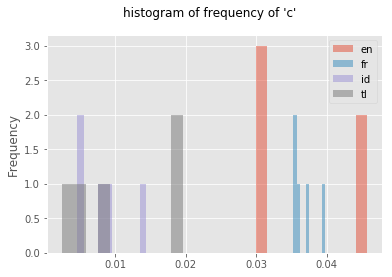

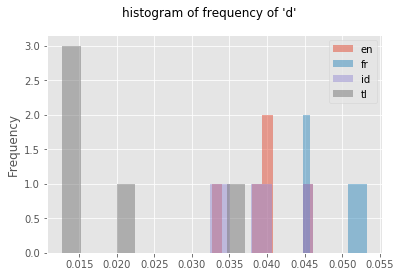

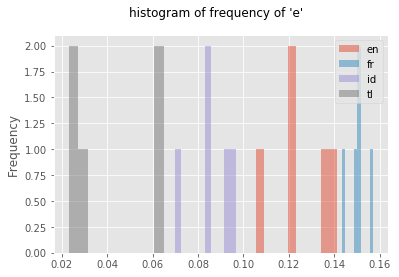

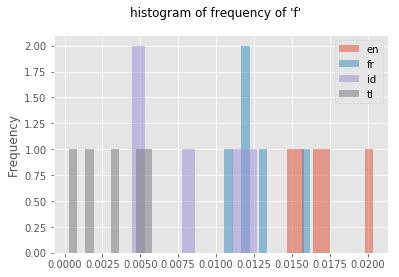

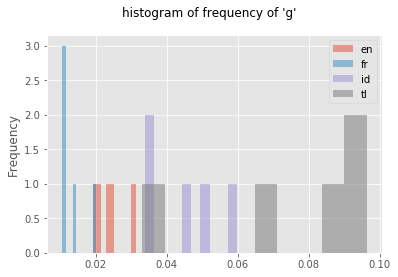

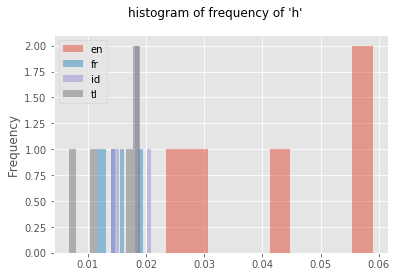

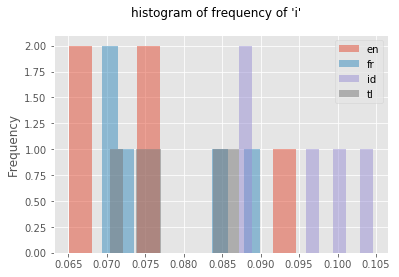

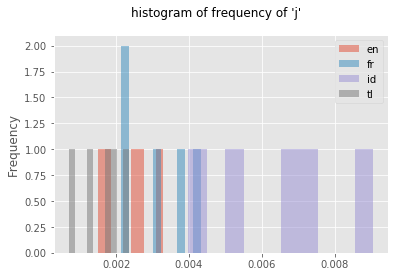

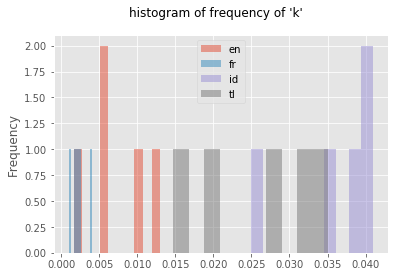

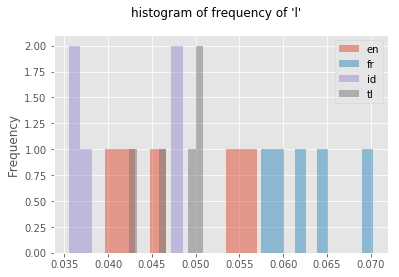

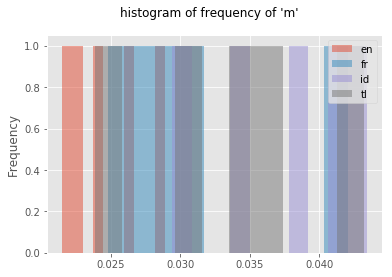

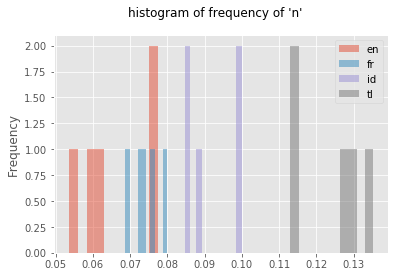

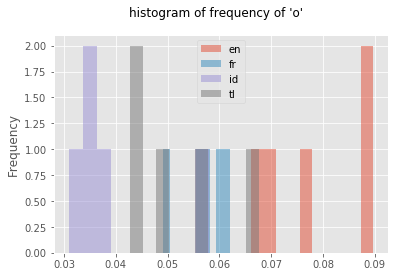

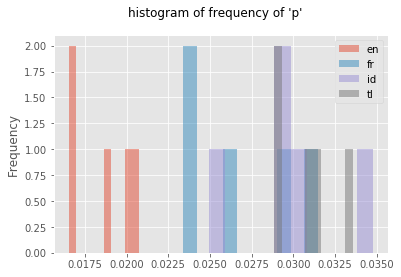

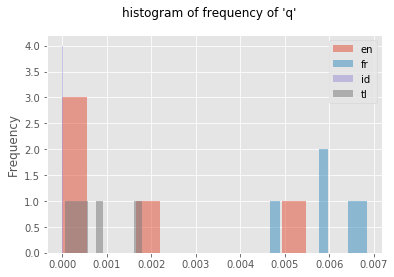

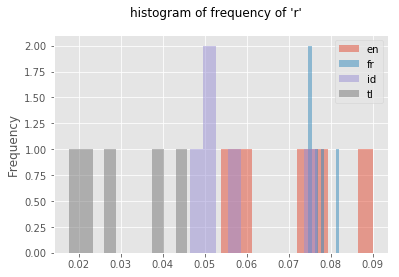

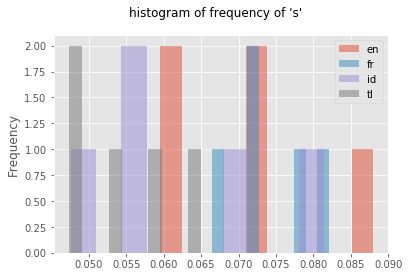

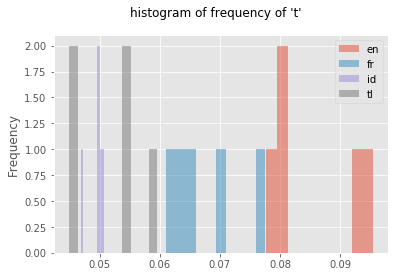

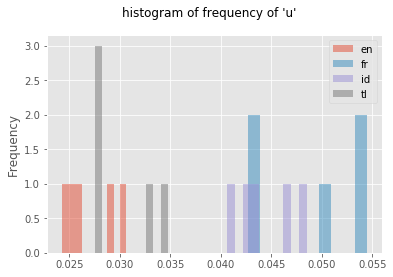

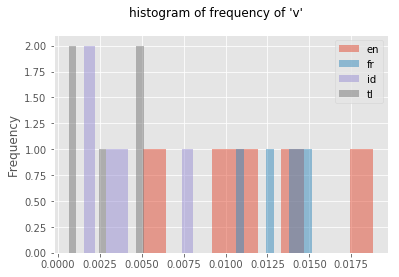

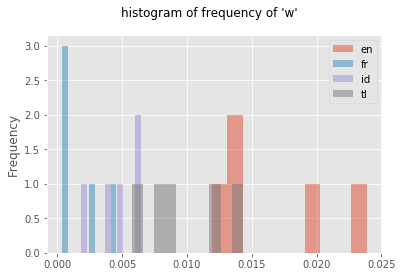

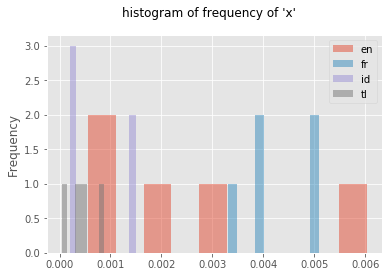

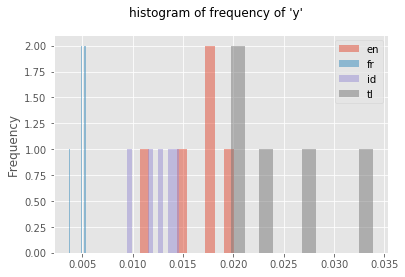

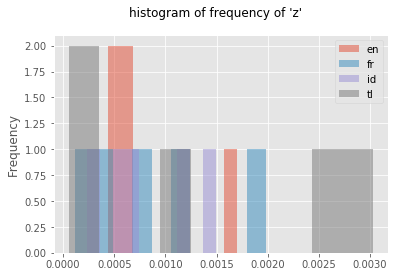

In [93]:
# 모든 알파벳(a-z)
for word in ascii_lowercase :
    for na in df_tmp['label'].unique() :
        # 국가별로 돌면서 해당 국가의 데이터만 획득
        df_tmp_na = df_tmp[df_tmp['label']==na]
        # 국가별 시각화
        # 한 번에 그려지는 데이터는 동일 색상으로 처리
        df_tmp_na[word].plot(kind = 'hist', alpha = 0.5, label = na)
    plt.legend()
    plt.suptitle("histogram of frequency of '%s'" %(word))
    plt.savefig('../data/graph/%s_freq.png' %(word))
    plt.show() 

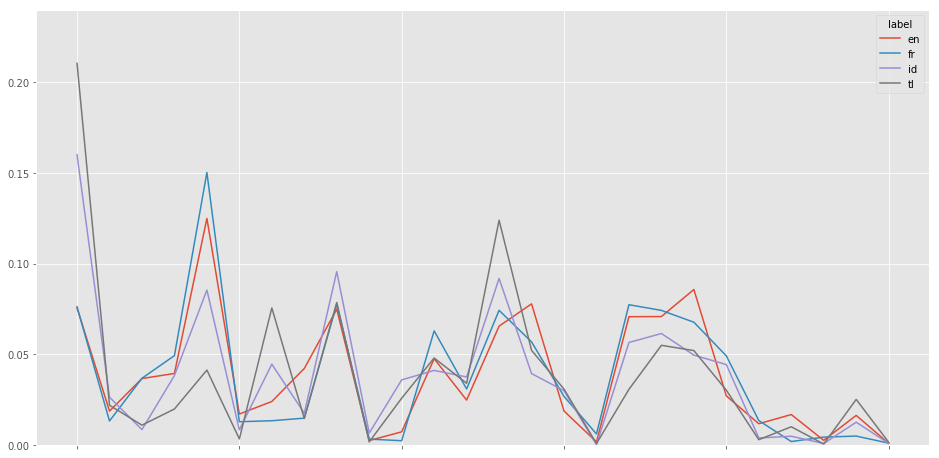

In [94]:
# 한 개의 차트에 국가별로 언어 빈도를 연결한다 (선형, line 차트)
plt.style.use('ggplot')
df_tmp_pv.plot(kind = 'line', figsize = (16, 8), ylim = (0, 0.24))
plt.show()
# 전체적인 사용 추이는 유사하나, 사용량이 현저하게 다르다

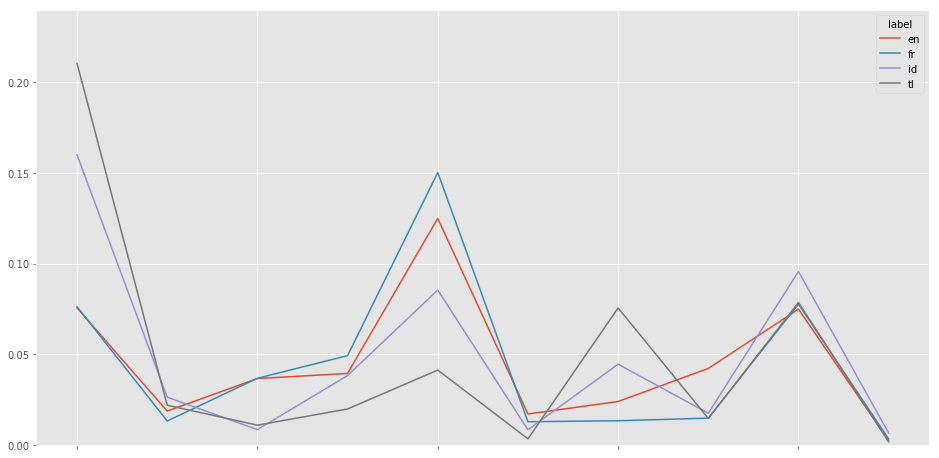

In [95]:
# 일부 구간만
df_tmp_pv.iloc[:10, :].plot(kind = 'line', figsize = (16, 8), ylim = (0, 0.24))
plt.show()
# e~g 구간의 추이는 인디아/타갈리아어 vs 영어/프랑스어 계열로 확실히 다르다

### 5. 데이터 모델링 or 모델구축 + 시각화
- 알고리즘 선택
- 훈련용 데이터, 테스트용 데이터 구성
- 훈련
- 예측모델 생성
- 새로운 데이터를 적용해서 예측
- 정확도 판단, 검증
--------------------------------------------------------------
- 파이프라인 구축
- 하이퍼 파라미터 튜닝
- 성능 평가

In [96]:
# 1. 알고리즘 선택
from sklearn import svm, metrics

In [97]:
# 1-1. 해당 알고리즘 객체 생성
# 생성할 때 파라미터를 대입 → 하이퍼파라미터 
# → 튜닝, 그 값의 여파로 성능/결과치가 변경
clf = svm.SVC(gamma = 'auto')

In [ ]:
# 2. 훈련데이터, 테스트데이터 구성 (위에서 구성 완료)
# 훈련 함수명이나, 기타 단위 모듈들은 공통적으로 사용될 수 있게 인터페이스화되어 있다
# 75%, 25%로 구성

In [103]:
len(train_data['freqs']), len(train_data['labels'])

(20, 20)

In [102]:
# 3. 훈련
clf.fit(train_data['freqs'], train_data['labels'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [105]:
# 4. 예측 모델, 예측 생성
# 5. 예측
predict = clf.predict( test_data['freqs'] )

In [106]:
predict

array(['en', 'en', 'fr', 'fr', 'en', 'id', 'tl', 'tl'], dtype='<U2')

In [108]:
# 6. 결과 확인
# test_data['labels'] : ['en', 'en', 'fr', 'fr', 'id', 'id', 'tl', 'tl']
ac_score = metrics.accuracy_score( test_data['labels'], predict )

In [109]:
# 훈련량에 비해 잘 나왔다
# 지향점은 95~97%
# 이를 목표로 잡고
# 그 이상은 과적합 문제에 봉착할 수 있어 따로 검토
ac_score

0.875

In [110]:
cl_report = metrics.classification_report( test_data['labels'], predict )
print(cl_report)
# precision : 정밀도
# recall : 재현율
# f1-score : 점수, 정확도
# support : 데이터에 응답한 샘플 수

             precision    recall  f1-score   support

         en       0.67      1.00      0.80         2
         fr       1.00      1.00      1.00         2
         id       1.00      0.50      0.67         2
         tl       1.00      1.00      1.00         2

avg / total       0.92      0.88      0.87         8



In [112]:
# 예측 모델 덤프(자료구조를 유지하면서 파일로 저장)
from sklearn.externals import joblib
joblib.dump(clf, '../data/clf_lang_20190830.model')
# 레이블(정답의 후보들)
# with open('../data/clf_lang_labels.txt', 'w') as f :
#     for label in list(set(train_data['labels'])) :
#         f.writelines(label + '\n')

['../data/clf_lang_20190830.model']

In [113]:
label_dic = {
    'fr' : '프랑스어',
    'id' : '인도네시아어',
    'tl' : '타갈리아어',
    'en' : '영어'
}

In [115]:
with open ('../data/clf_lang_labels.label', 'w', encoding = 'utf-8') as f :
    json.dump(label_dic, f)

### 6. 시스템 통합 or 솔루션/서비스/레포트
- flask
- mariadb : 데이터 축적, 예측 모델 데이터 업그레이드/다운그레이드 정보

In [ ]:
# conda list 확인 후 flask 없으면
# conda install -y flask

- DB를 연동하여 언어 감지 및 번역 로그 남김
- 파파고 번역과 연동하여 실제 번역 진행
- 선순환 구조에 대한 고민(모델의 업그레이드/다운그레이드 전략)